In [1]:
from __future__ import division
import requests
import numpy as np
import tensorflow as tf
import collections
import random
from helper_functions import *
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string
from tqdm import tqdm
from nltk import word_tokenize
import matplotlib.pyplot as plt
import itertools
%matplotlib inline
plt.style.use("fivethirtyeight")

The goal of this notebook is to become familiar with the process of learning word embeddings and algorithms like ```skipgram``` and ```continuous bag of words``` used to train ```Word2Vec``` embeddings. Some of this code (especially the helper functions I have in the other file are taken from various tutorials). All of the preprocessing however is mine and could be missing something!

# Step 1: Read in the data

In [2]:
# Let's read the data
url = "http://www.gutenberg.org/files/2554/2554.txt"
response = requests.request("GET", url)
txt = response.content.decode('utf8')

# Now let's find the start and end indices of the content
start = txt.find("PART I")
end = txt.rfind("End of Project Gutenberg's Crime")
txt = txt[start:end]
txt[:10]

u'PART I\r\n\r\n'

In [3]:
tokens = word_tokenize(txt)
remove_punctuation = [str(word).translate(string.maketrans("",""), string.punctuation) for word in tokens]
drop_empty_strings = filter(None, remove_punctuation)
lowercase = [w.lower() for w in drop_empty_strings]
remove_stopwords = [w for w in lowercase if w not in  stopwords.words('english')]

In [4]:
# free up some space from the intermediate steps
del remove_punctuation
del drop_empty_strings
del lowercase
del txt

In [5]:
print("Total # of tokens: {}".format(len(remove_stopwords)))
print("# of unique tokens: {}".format(len(set(remove_stopwords))))

Total # of tokens: 92702
# of unique tokens: 9499


In [6]:
# distribution of frequencies
counter = collections.Counter(remove_stopwords)

In [7]:
percentiles = np.arange(0, 101,10)
percs = np.percentile(counter.values(), percentiles).astype(int)
for n, p in zip(percs, percentiles):
    print(str(p)+"th percentile: {}".format(n))

0th percentile: 1
10th percentile: 1
20th percentile: 1
30th percentile: 1
40th percentile: 1
50th percentile: 2
60th percentile: 3
70th percentile: 5
80th percentile: 8
90th percentile: 18
100th percentile: 1065


In [8]:
# stemming might actually be a good idea
sorted(counter.iterkeys())

['14',
 '1861',
 '3',
 '47',
 '5percent',
 '8',
 '9',
 'aach',
 'aah',
 'aback',
 'abandon',
 'abandoned',
 'abandoning',
 'aberration',
 'ability',
 'abject',
 'abjectly',
 'abjectness',
 'abjure',
 'able',
 'abnormal',
 'abnormality',
 'abolition',
 'abominably',
 'abortions',
 'abraham',
 'abroad',
 'abrupt',
 'abruptly',
 'abscess',
 'absence',
 'absent',
 'absentminded',
 'absentmindedly',
 'absolute',
 'absolutely',
 'absorbed',
 'abstain',
 'abstract',
 'absurd',
 'absurdity',
 'absurdly',
 'abundant',
 'abuse',
 'abused',
 'abusing',
 'abyss',
 'academy',
 'accelerate',
 'accent',
 'accept',
 'acceptance',
 'accepted',
 'accident',
 'accidentally',
 'accommodating',
 'accompanied',
 'accompaniment',
 'accompanying',
 'accomplice',
 'accomplished',
 'accord',
 'accordance',
 'according',
 'account',
 'accounted',
 'accounts',
 'accumulated',
 'accurately',
 'accursed',
 'accusation',
 'accusations',
 'accuse',
 'accused',
 'accusing',
 'accustomed',
 'ach',
 'ache',
 'ached',
 '

In [9]:
ps = PorterStemmer()
stemmed = [str(ps.stem(w)) for w in remove_stopwords]
zip(stemmed[:10], remove_stopwords[:10])

[('part', 'part'),
 ('chapter', 'chapter'),
 ('except', 'exceptionally'),
 ('hot', 'hot'),
 ('even', 'evening'),
 ('earli', 'early'),
 ('juli', 'july'),
 ('young', 'young'),
 ('man', 'man'),
 ('came', 'came')]

In [10]:
del remove_stopwords

In [11]:
counter = collections.Counter(stemmed)

In [12]:
percentiles = np.arange(0, 101,10)
percs = np.percentile(counter.values(), percentiles).astype(int)
for n, p in zip(percs, percentiles):
    print(str(p)+"th percentile: {}".format(n))

0th percentile: 1
10th percentile: 1
20th percentile: 1
30th percentile: 1
40th percentile: 2
50th percentile: 3
60th percentile: 4
70th percentile: 7
80th percentile: 13
90th percentile: 30
100th percentile: 1065


In [13]:
import operator
sorted(counter.iteritems(), key=operator.itemgetter(1), reverse=True)

[('nt', 1065),
 ('raskolnikov', 785),
 ('look', 694),
 ('one', 662),
 ('would', 614),
 ('know', 603),
 ('come', 579),
 ('go', 552),
 ('could', 538),
 ('said', 518),
 ('like', 511),
 ('man', 477),
 ('time', 448),
 ('though', 442),
 ('see', 441),
 ('sonia', 402),
 ('even', 399),
 ('say', 378),
 ('went', 355),
 ('razumihin', 348),
 ('thought', 340),
 ('dounia', 324),
 ('hand', 323),
 ('well', 323),
 ('ask', 322),
 ('room', 315),
 ('want', 306),
 ('must', 306),
 ('ivanovna', 304),
 ('cri', 303),
 ('last', 296),
 ('think', 294),
 ('ye', 292),
 ('someth', 292),
 ('suddenli', 292),
 ('face', 291),
 ('littl', 289),
 ('petrovitch', 287),
 ('noth', 285),
 ('get', 285),
 ('turn', 285),
 ('make', 277),
 ('tell', 275),
 ('still', 271),
 ('seem', 271),
 ('way', 268),
 ('day', 267),
 ('began', 265),
 ('away', 263),
 ('eye', 258),
 ('take', 249),
 ('thing', 247),
 ('two', 241),
 ('came', 240),
 ('door', 236),
 ('made', 229),
 ('word', 228),
 ('first', 224),
 ('mother', 221),
 ('without', 220),
 ('righ

In [14]:
print("Total # of tokens: {}".format(len(stemmed)))
print("# of unique tokens: {}".format(len(set(stemmed))))

Total # of tokens: 92702
# of unique tokens: 6282


# Latent Semantic Analysis

Let's try to see how a count-based approach could help in generating informative word embeddings.

In [15]:
# construct co-occurence matrix
window_size = 3 # on each size
vocabulary_size = 1000 # ~ 0.2 * 6000

In [16]:
top_n = sorted(counter.iteritems(), key=operator.itemgetter(1), reverse=True)[:vocabulary_size]

dictionary = {"UNK":0} # for the words that didn't make it
for word, count in top_n:
    dictionary[word]=len(dictionary)

reverse_dictionary = {} # reverse mapping compared to above
for word, index in dictionary.iteritems():
    reverse_dictionary[index] = word

In [17]:
stemmed_id = []

for w in stemmed:
    if w not in dictionary.keys():
        stemmed_id.append(0) # found an unknown word
    else:
        stemmed_id.append(dictionary[w])
        
zip(stemmed_id, stemmed)[:10]

[(224, 'part'),
 (501, 'chapter'),
 (491, 'except'),
 (0, 'hot'),
 (17, 'even'),
 (0, 'earli'),
 (0, 'juli'),
 (170, 'young'),
 (12, 'man'),
 (54, 'came')]

In [18]:
# Now implement a sliding window to construct coocurence matrix
coocurence = np.zeros([vocabulary_size+1, vocabulary_size+1])
windows = [np.arange(i, i+2*window_size+1) for i in range(0, len(stemmed_id)-2*window_size)]

In [19]:
# build coocurence matrix
for w in tqdm(windows):
    words = np.array(stemmed_id)[w]
    for i, j in itertools.combinations(words, 2):
        coocurence[i, j]+=1
        coocurence[j, i]+=1

100%|██████████| 92696/92696 [07:27<00:00, 207.27it/s]


In [20]:
from sklearn.decomposition import PCA 

pca = PCA(n_components=300)
embeddings = pca.fit_transform(coocurence)

In [21]:
# from scipy.spatial.distance import cosine

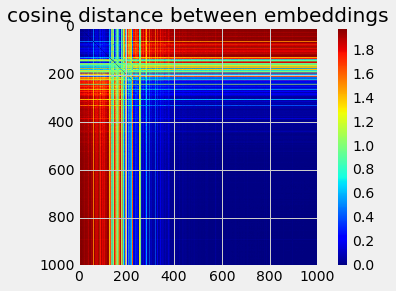

In [22]:
from sklearn.metrics import pairwise_distances

cosine_distances = pairwise_distances(embeddings, metric='cosine')
plt.imshow(cosine_distances)
plt.colorbar()
plt.title("cosine distance between embeddings")

In [23]:
# find the most similar words
similar_pairs = np.argwhere(np.logical_and(cosine_distances>0.8, cosine_distances<1.2))
word_pairs = []
for w1, w2 in similar_pairs:
    if w1!=0 and w2 !=0 and w1!=1 and w2 !=1 and w1!=w2:
        word_pairs.append((reverse_dictionary[w1], reverse_dictionary[w2]))

In [24]:
dictionary['avdotya']

157

In [25]:
np.argsort(cosine_distances[157, :])[:10]

array([157, 217, 205, 235, 139, 304, 443, 266, 354, 260])

In [26]:
reverse_dictionary[217], reverse_dictionary[235], reverse_dictionary[139], reverse_dictionary[304], reverse_dictionary[443]

('possibl', 'observ', 'rodya', 'respect', 'marri')

Interesting results. Definitely worth some more exploration! However, the count-based approach is somewhat silly. Let's try something more sophisticated. 

# Skipgram with Tensorflow!

## Preprocess the data

In [16]:
vocabulary_size = 1000
window_size = 3

In [17]:
 # agreed vocabulary size

data, count, dictionary, reverse_dictionary = build_dataset(stemmed, vocabulary_size)

print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10], [reverse_dictionary[i] for i in data[:10]])

('Most common words (+UNK)', [['UNK', 19905], ('nt', 1065), ('raskolnikov', 785), ('look', 694), ('one', 662)])
('Sample data', [224, 501, 491, 0, 17, 0, 0, 170, 12, 54], ['part', 'chapter', 'except', 'UNK', 'even', 'UNK', 'UNK', 'young', 'man', 'came'])


## Generate a batch for the skipgram model

Our goal is to put the data in the following format:

```([the, brown], quick), ([quick, fox], brown), ([brown, jumped], fox), ...```

In the above example we have a window size of 1. The list contains the context words and the other word is the middle word. We will try to predict the context words from the center word (skipgram model), thereby learning the distributed representations of the word.

In [29]:
batch, labels = generate_batch_skip(batch_size=128, num_skips=2, skip_window=1, data = data)
for i in range(8):
    print(batch[i], reverse_dictionary[batch[i]],
        '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

(501, 'chapter', '->', 224, 'part')
(501, 'chapter', '->', 491, 'except')
(491, 'except', '->', 501, 'chapter')
(491, 'except', '->', 0, 'UNK')
(0, 'UNK', '->', 491, 'except')
(0, 'UNK', '->', 17, 'even')
(17, 'even', '->', 0, 'UNK')
(17, 'even', '->', 0, 'UNK')


As an example, the fragment above is ``` ... to go through the course prescribed ...```.

First we look at go as the center word (surrounded by ```to``` and ```through```) and so on. As a result we have go as an input and to and through as targets. We should try making the window size larger although this would increase our computation.

#  The skipgram model

Now let's actually dive into bulding the model. The skipgram model initially consists of an embedding matrix for all the context words. 

1. Given a center word, we get its embedding from the embedding matrix we are learning. 

2. Then take the word embedding and dot-product it with  

In [30]:
# First we need to define some hyperparameters for our model

batch_size = 128
embedding_size =300  # Dimension of the embedding vector.
skip_window = window_size     # How many words to consider left and right.

# Time for Tensorflow!

Now that we have seen that the model itself is not super complicated, let's look at the TF implementation.

In [31]:
# Now let's define some placeholders for the inputs to our model
train_inputs = tf.placeholder(tf.int32, shape=[batch_size])
train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
# one hot encode labels since we will be using categorical cross-entropy
train_labels_ = tf.one_hot(train_labels, vocabulary_size, dtype=tf.float32) 

In [32]:
# First let's define the variables we will need

center_word_embeddings = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, embedding_size], stddev=0.01,
                                                        dtype=tf.float32))
context_word_embeddings = tf.Variable(tf.truncated_normal(shape=[vocabulary_size, embedding_size], stddev=0.01,
                                                         dtype=tf.float32), name="word_embedding")
final_layer_biases = tf.Variable(tf.constant(0.1, shape=[vocabulary_size,1], dtype=tf.float32))

In [33]:
# Instead of doing the dot product by ourselves there is a nice tensorflow 
embed = tf.nn.embedding_lookup(center_word_embeddings, train_inputs)

In [34]:
context_word_embeddings, embed

(<tf.Variable 'word_embedding:0' shape=(1000, 300) dtype=float32_ref>,
 <tf.Tensor 'embedding_lookup:0' shape=(128, 300) dtype=float32>)

In [35]:
# Dot product word_embedding with the context embedding matrix, add bias and pass through softmax
linear_combination = tf.matmul(context_word_embeddings, tf.transpose(embed)) + final_layer_biases
linear_combination = tf.transpose(linear_combination)
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = train_labels_, logits=linear_combination))

In [36]:
#optimize variables, aka bias, context_word_embedding, center_word_embedding
optimizer = tf.train.AdamOptimizer(0.01)
train_step = optimizer.minimize(loss)

In [37]:
norm = tf.sqrt(tf.reduce_sum(tf.square(context_word_embeddings), 1, keep_dims=True))
normalized_embeddings = context_word_embeddings / norm

In [39]:
num_steps=10000
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()

# Start a tensorboard writer to get the data from the training
experiment_name = "no_stopwords_punctuation_regular_softmax_cross_entropy_with_logits_adam_lr=001"
writer = tf.summary.FileWriter("tensorboard_checkpoints/"+experiment_name)
writer.add_graph(sess.graph)

# We must initialize all variables before we use them.
init.run()

print('Initialized variables')

average_loss = 0

for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch_skip(
        batch_size, 2, skip_window, data)
    feed_dict = {train_inputs: batch_inputs, train_labels: batch_labels}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = sess.run([train_step, loss], feed_dict=feed_dict)
    average_loss += loss_val
    
    if step % 500 == 0:
        # The average loss is an estimate of the loss over the last 2000 batches.
        print 'Average loss at step '+str(step)+':', average_loss/step
        average_loss = 0
        
final_embeddings = normalized_embeddings.eval()

Initialized variables
Average loss at step 0: inf
Average loss at step 500: 5.92952239704
Average loss at step 1000: 2.90187691641
Average loss at step 1500: 1.9021585207
Average loss at step 2000: 1.42529309273
Average loss at step 2500: 1.14142968826
Average loss at step 3000: 0.947037543774
Average loss at step 3500: 0.80923547554
Average loss at step 4000: 0.71052952826
Average loss at step 4500: 0.626590758165
Average loss at step 5000: 0.569820282459
Average loss at step 5500: 0.513240822098
Average loss at step 6000: 0.469822313944
Average loss at step 6500: 0.438176827504
Average loss at step 7000: 0.404599061012
Average loss at step 7500: 0.375365854518
Average loss at step 8000: 0.353732238591
Average loss at step 8500: 0.333684221829
Average loss at step 9000: 0.312112928073
Average loss at step 9500: 0.298011097707


In [40]:
embeddings = normalized_embeddings.eval()

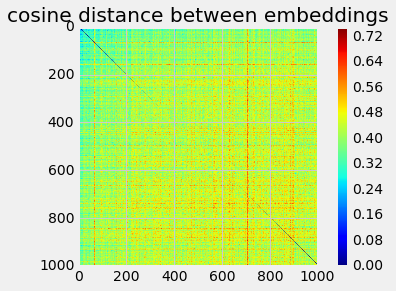

In [41]:
cosine_distances = pairwise_distances(embeddings, metric='cosine')
plt.imshow(cosine_distances)
plt.colorbar()
plt.title("cosine distance between embeddings")

In [42]:
dictionary['sonia']

16

In [43]:
[reverse_dictionary[i] for i in np.argsort(cosine_distances[16, :])[1:21]] # many people

['lebeziatnikov',
 'UNK',
 'katerina',
 'went',
 'pyotr',
 'look',
 'cri',
 'began',
 'ivanovna',
 'hand',
 'though',
 'suddenli',
 'fresh',
 'petrovitch',
 'say',
 'said',
 'ask',
 'raskolnikov',
 'almost',
 'thought']

# CBOW implementation

Same idea as with the skipgram model but performs slightly better and has a little bit of a different architecture.
![](cbow_architecture.png)

In [18]:
window_size=5
vocabulary_size=1000
embedding_size=300

In [38]:
input_ = tf.placeholder(dtype=tf.int32, shape=[1, 2*window_size])
label_ = tf.placeholder(dtype=tf.int32, shape=[1,])
label_ohe = tf.reshape(tf.one_hot(label_, vocabulary_size, dtype=tf.float32), (1000, ))
embeddings = tf.Variable(tf.truncated_normal(dtype=tf.float32, shape=[vocabulary_size, embedding_size], stddev=0.01))
W = tf.Variable(tf.truncated_normal(dtype=tf.float32, shape=[vocabulary_size, embedding_size], stddev=0.01))
b = tf.Variable(tf.constant(0.1))

In [39]:
input_embeddings = tf.nn.embedding_lookup(embeddings, input_)
mean_embedding = tf.reduce_mean(input_embeddings, 1)
log_output = tf.matmul(W, tf.transpose(mean_embedding))+b
log_output = tf.reshape(log_output, (1000,))

In [40]:
loss = tf.nn.softmax_cross_entropy_with_logits(labels = label_ohe, logits=log_output)
train_step = tf.train.GradientDescentOptimizer(0.1).minimize(loss)

In [46]:
norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
normalized_embeddings = embeddings / norm

In [57]:
num_steps=100000
sess = tf.Session()
init = tf.global_variables_initializer()

# We must initialize all variables before we use them.
sess.run([init])

print('Initialized variables')

average_loss = 0

for step in xrange(num_steps):
    batch_inputs, batch_labels = generate_batch_cbow(1, window_size, data)
    feed_dict = {input_: batch_inputs, label_: batch_labels.flatten()}

    # We perform one update step by evaluating the optimizer op (including it
    # in the list of returned values for session.run()
    _, loss_val = sess.run([train_step, loss], feed_dict=feed_dict)
    average_loss += loss_val

    if step % 5000 == 0:
        # The average loss is an estimate of the loss over the last 2000 batches.
        print 'Average loss at step '+str(step)+':', average_loss/step
        average_loss = 0
        
[finalized_embeddings] = sess.run([normalized_embeddings])

Initialized variables
Average loss at step 0: inf
Average loss at step 5000: 6.13501461361
Average loss at step 10000: 2.94166434018
Average loss at step 15000: 1.90742601439
Average loss at step 20000: 1.42495225919
Average loss at step 25000: 1.12730394684
Average loss at step 30000: 0.930146690898
Average loss at step 35000: 0.801318968703
Average loss at step 40000: 0.699260721989
Average loss at step 45000: 0.625428187637
Average loss at step 50000: 0.561338349553
Average loss at step 55000: 0.509215155136
Average loss at step 60000: 0.469019178376
Average loss at step 65000: 0.432755452494
Average loss at step 70000: 0.396197281399
Average loss at step 75000: 0.367586310024
Average loss at step 80000: 0.349568382245
Average loss at step 85000: 0.324894672489
Average loss at step 90000: 0.309720169485
Average loss at step 95000: 0.293171266849


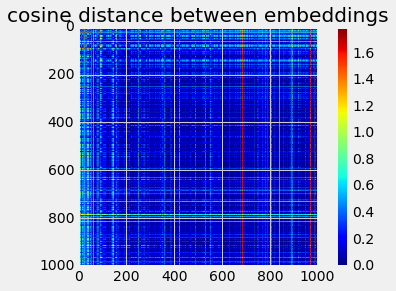

In [58]:
from sklearn.metrics import pairwise_distances

cosine_distances = pairwise_distances(finalized_embeddings, metric='cosine')
plt.imshow(cosine_distances)
plt.colorbar()
plt.title("cosine distance between embeddings")

In [76]:
dictionary['eye']

50

In [77]:
[reverse_dictionary[i] for i in np.argwhere(cosine_distances[50, :]<0.1).flatten()] # many people

['hand',
 'room',
 'face',
 'turn',
 'eye',
 'almost',
 'stood',
 'felt',
 'open',
 'took',
 'left',
 'stand',
 'tabl',
 'round',
 'window',
 'ran',
 'stair',
 'corner',
 'light',
 'close',
 'pocket',
 'gaze',
 'lip',
 'paper',
 'stare',
 'wall',
 'toward',
 'pace',
 'white',
 'shoulder',
 'wide']

Some quite exciting stuff here! Words closer to the word ```eye``` include ```face, hand, window, stare, light```. All of these seem pretty exciting results! Semantically, the majority of results are all relevent. (Or at least most of them)!

This is the end of my little exploration of learning word embeddings with tensorflow. Seems like simple count-based approaches don't perform as well while CBOW seemed to give the best results. Could have also explored LSTM embeddings but seems like coprus is too small to get exciting stuff. Perhaps a good next step would be to figure out how to use pyspark and let the models learn with more data.